In [43]:
from matplotlib import pyplot as plt
import numpy as np
import joblib
import os
import pandas as pd
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import numpy as np

import numpy as np
import pandas as pd
import joblib

from calimera import CALIMERA

from sklearn.metrics import accuracy_score



### Time Series Conversion of Lab created data

In [44]:

def load_bugsense_data():
    data = pd.read_csv('/media/storage/users/go98kef/TimeSeriesConversion/time_series_data.csv', header=None)
    labels = pd.read_csv('/media/storage/users/go98kef/TimeSeriesConversion/time_series_labels.csv', usecols=[0], header=None)
    concentrations = pd.read_csv('/media/storage/users/go98kef/TimeSeriesConversion/time_series_labels.csv', usecols=[1], header=None)
    


    # Calculate number of complete groups of 80
    n_samples = len(data) // 80

    # Reshape data into groups of 80
    data_grouped = data.values.reshape(n_samples, 80, 24).transpose(0, 2, 1)
    labels_grouped = labels.values[::80]  # Take every 80th label
    concentrations_grouped = concentrations.values[::80]  # Take every 80th label

    # Generate random split indices (70% train, 30% test)
    train_size = int(0.7 * n_samples)
    test = int(0.3 * n_samples/2)
    indices = np.random.permutation(n_samples)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+test]
    test_indices = indices[train_size+test:]
    

    # Split data and labels
    X_train = data_grouped[train_indices]
    X_test = data_grouped[test_indices]
    y_train = labels_grouped[train_indices]
    y_test = labels_grouped[test_indices]
    X_val = data_grouped[val_indices]
    y_val = labels_grouped[val_indices]
    con_test = concentrations_grouped[test_indices]
    

    
    return X_train, y_train.squeeze(), X_val, y_val.squeeze(), X_test, y_test.squeeze(), con_test.squeeze()


#### Testing with artificial Data

In [ ]:
if __name__ == '__main__':
    X_train, y_train, X_val, y_val, X_test, y_test, con_test = load_bugsense_data()
    accuracy_scores = []
    earliness_scores = []
    cost_scores = []
    
    for delay_penalty in range(1,11):
        model = CALIMERA(delay_penalty=delay_penalty/10)
        model.fit(X_train, y_train)

        stop_timestamps, y_pred = model.test(X_val)
        
        accuracy = accuracy_score(y_val, y_pred)
        earliness = 1- sum(stop_timestamps) / (X_val.shape[-1] * X_val.shape[0])
        cost = 1.0 - accuracy + delay_penalty/10 * earliness
        print(f'Accuracy: {accuracy}\nEarliness: {earliness}\nCost: {cost}')

        accuracy_scores.append(accuracy)
        earliness_scores.append(earliness)
        cost_scores.append(cost)
        model_filename = f'saved_models/calimera_model_delay_{delay_penalty / 10}.joblib'
        joblib.dump(model, model_filename)
    

    print(f'Accuracy scores: {accuracy_scores}')
    print(f'Earliness scores: {earliness_scores}')
    print(f'Cost scores: {cost_scores}')

    print(type(X_test))

In [40]:
data = pd.read_csv('/media/storage/users/go98kef/TimeSeriesConversion/generative_models_time_series_data.csv', header=None)
labels = pd.read_csv('/media/storage/users/go98kef/TimeSeriesConversion/generative_models_time_series_labels.csv', usecols=[0], header=None)

n_samples = len(data) // 80
    # Reshape data into groups of 80
data_grouped = data.values.reshape(n_samples, 80, 24).transpose(0, 2, 1)
labels_grouped = labels.values[::80]  # Take every 80th label

train_size = int(1*n_samples)
indices = np.random.permutation(n_samples)

test_indices = indices[:train_size]


X_test = data_grouped[test_indices]
print(type(X_test))
y_test = labels_grouped[test_indices]
y_test = y_test.squeeze()

print(test_indices)

<class 'numpy.ndarray'>
[17 15 35 29 22  2 36 26 19 21 32  3 23 34  7 27 37 25 13  8  1 38 30  0
 24 11  6 14 12 20 16 31  4 28 33 39 10  5  9 18]


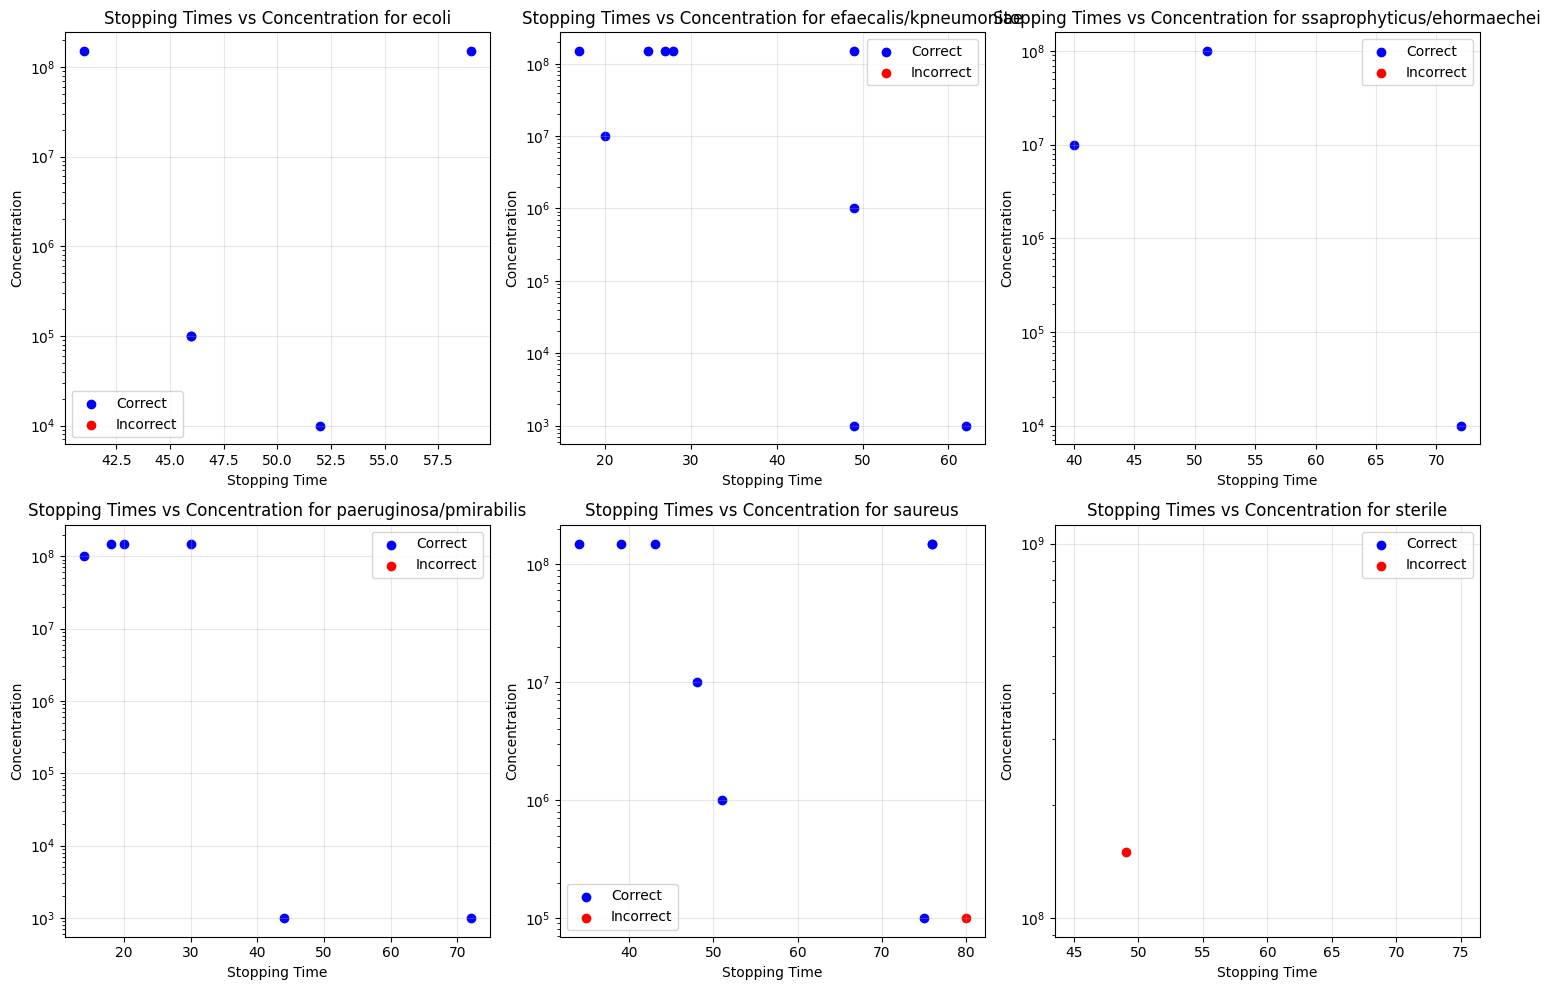

Accuracy: 0.9459459459459459
Earliness: 0.41148648648648645
Cost: 0.05816891891891892


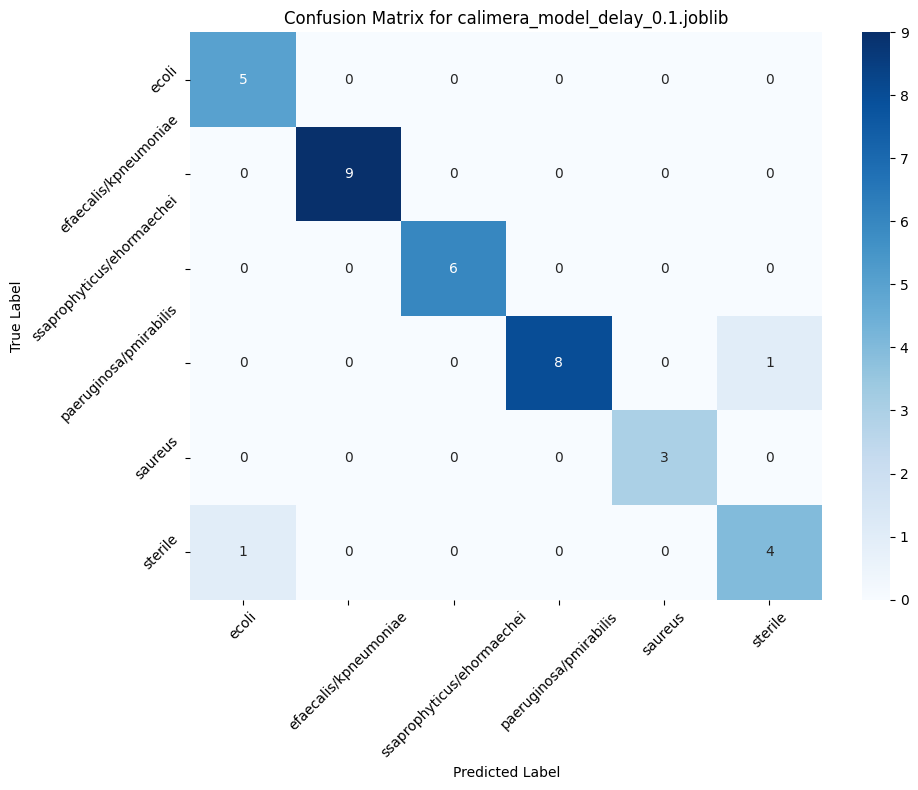

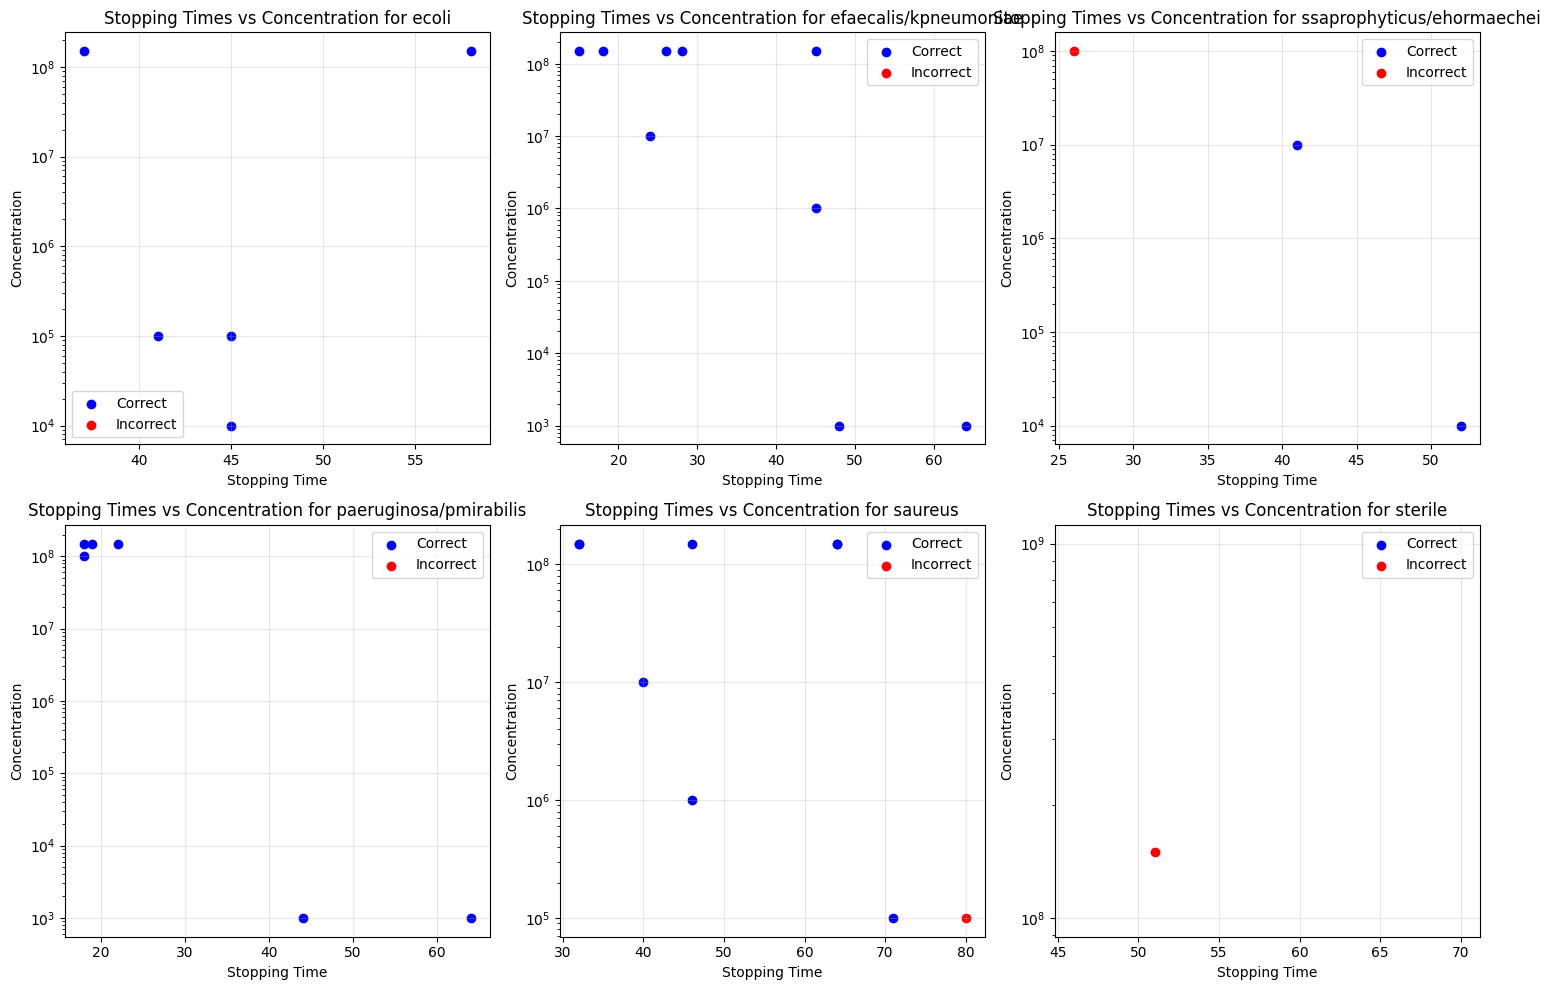

Accuracy: 0.918918918918919
Earliness: 0.45945945945945943
Cost: 0.09027027027027022


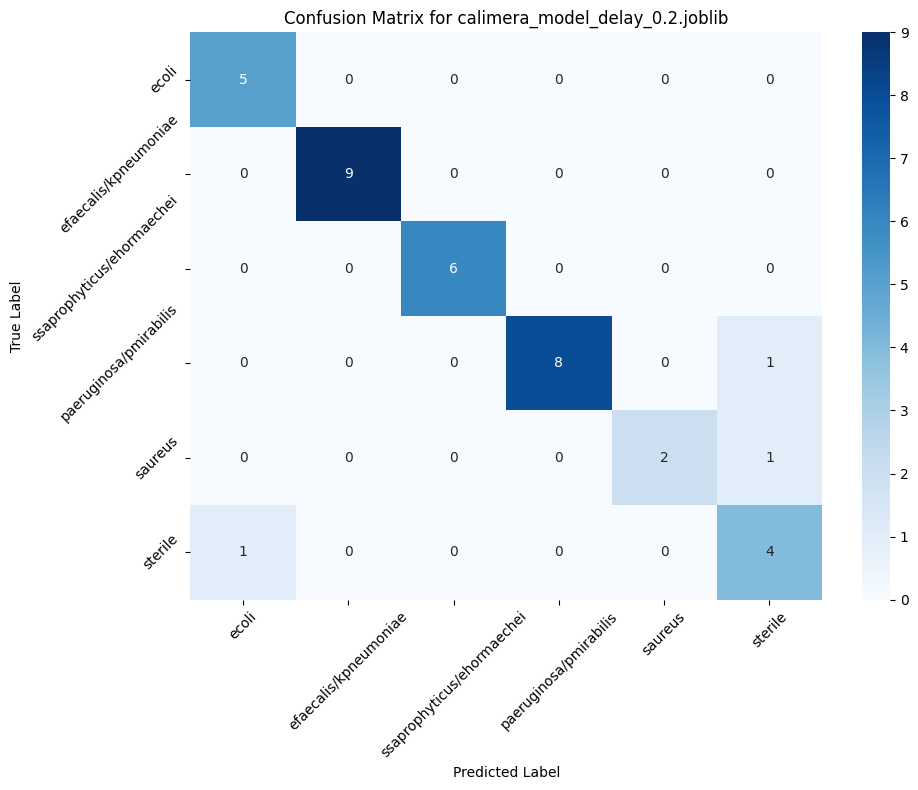

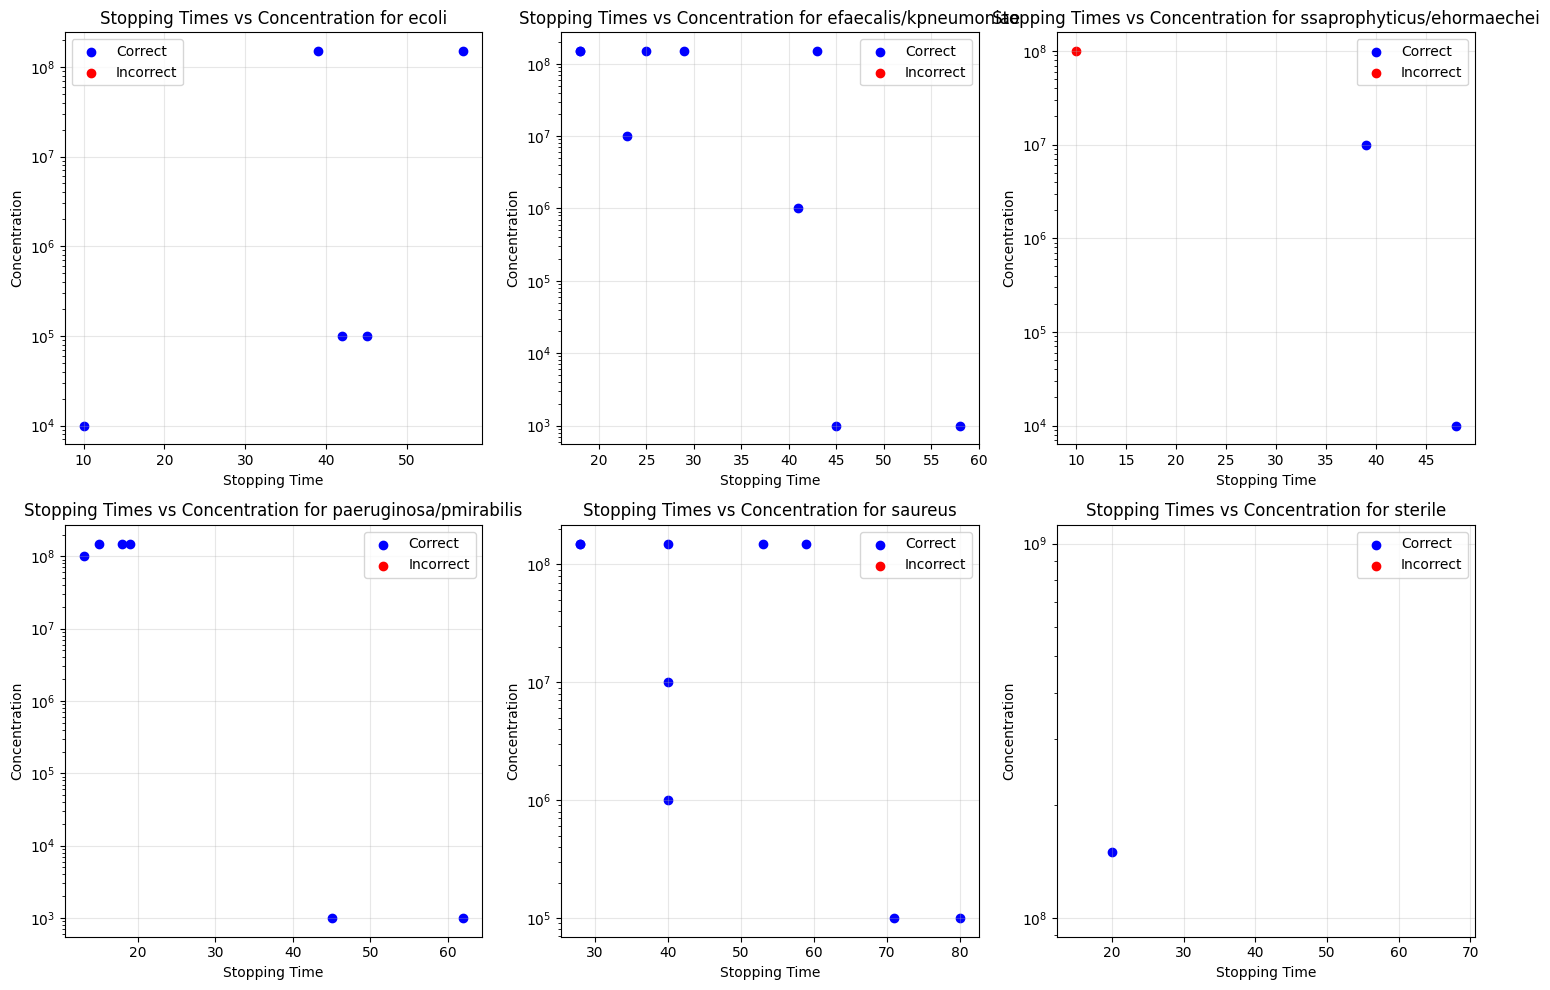

Accuracy: 0.9459459459459459
Earliness: 0.5260135135135136
Cost: 0.06983445945945946


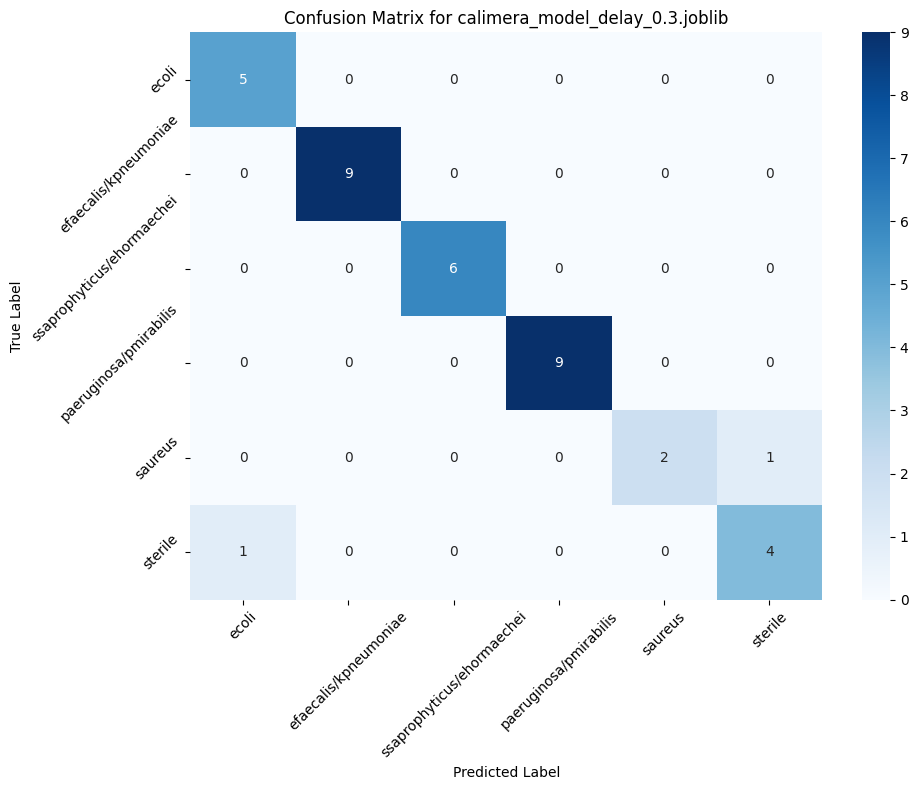

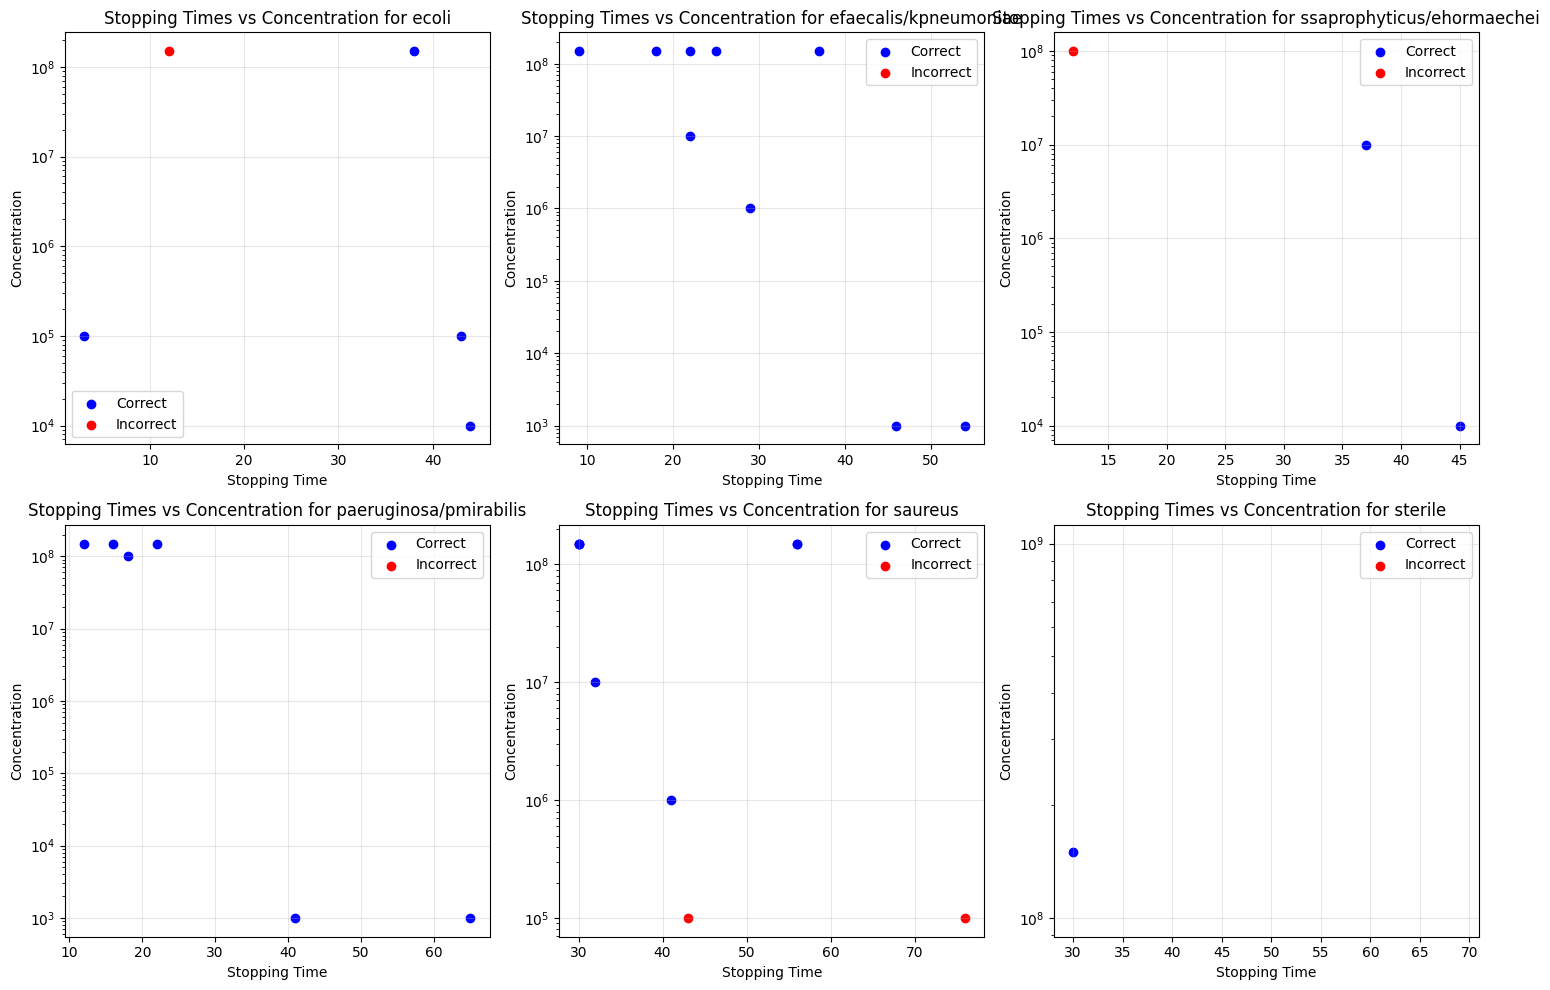

Accuracy: 0.8648648648648649
Earliness: 0.5574324324324325
Cost: 0.15743243243243238


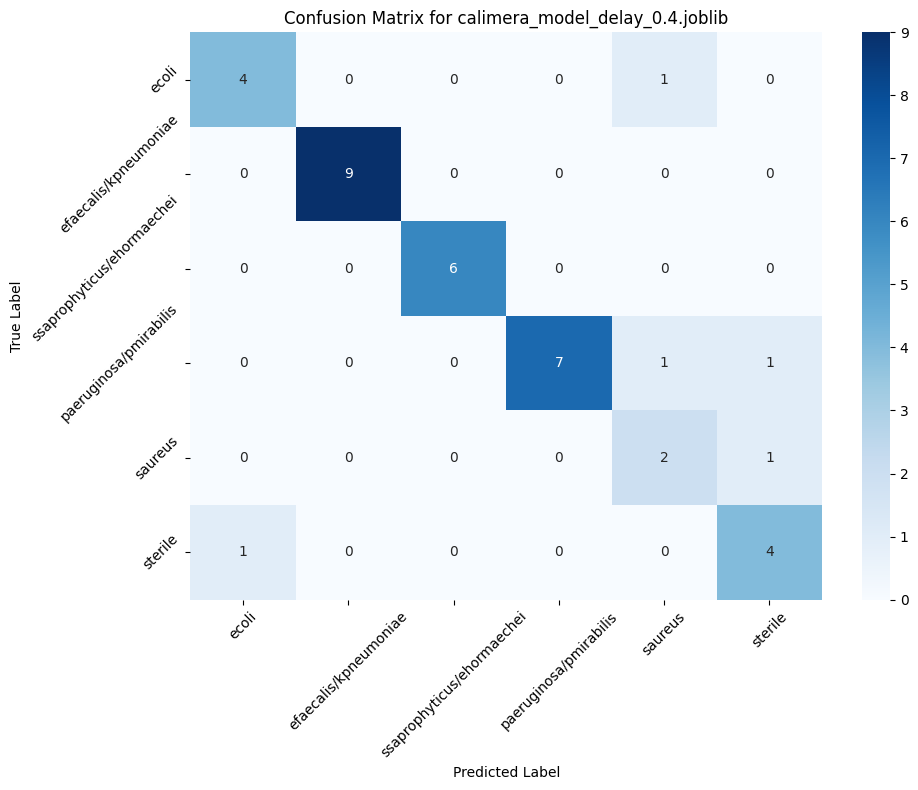

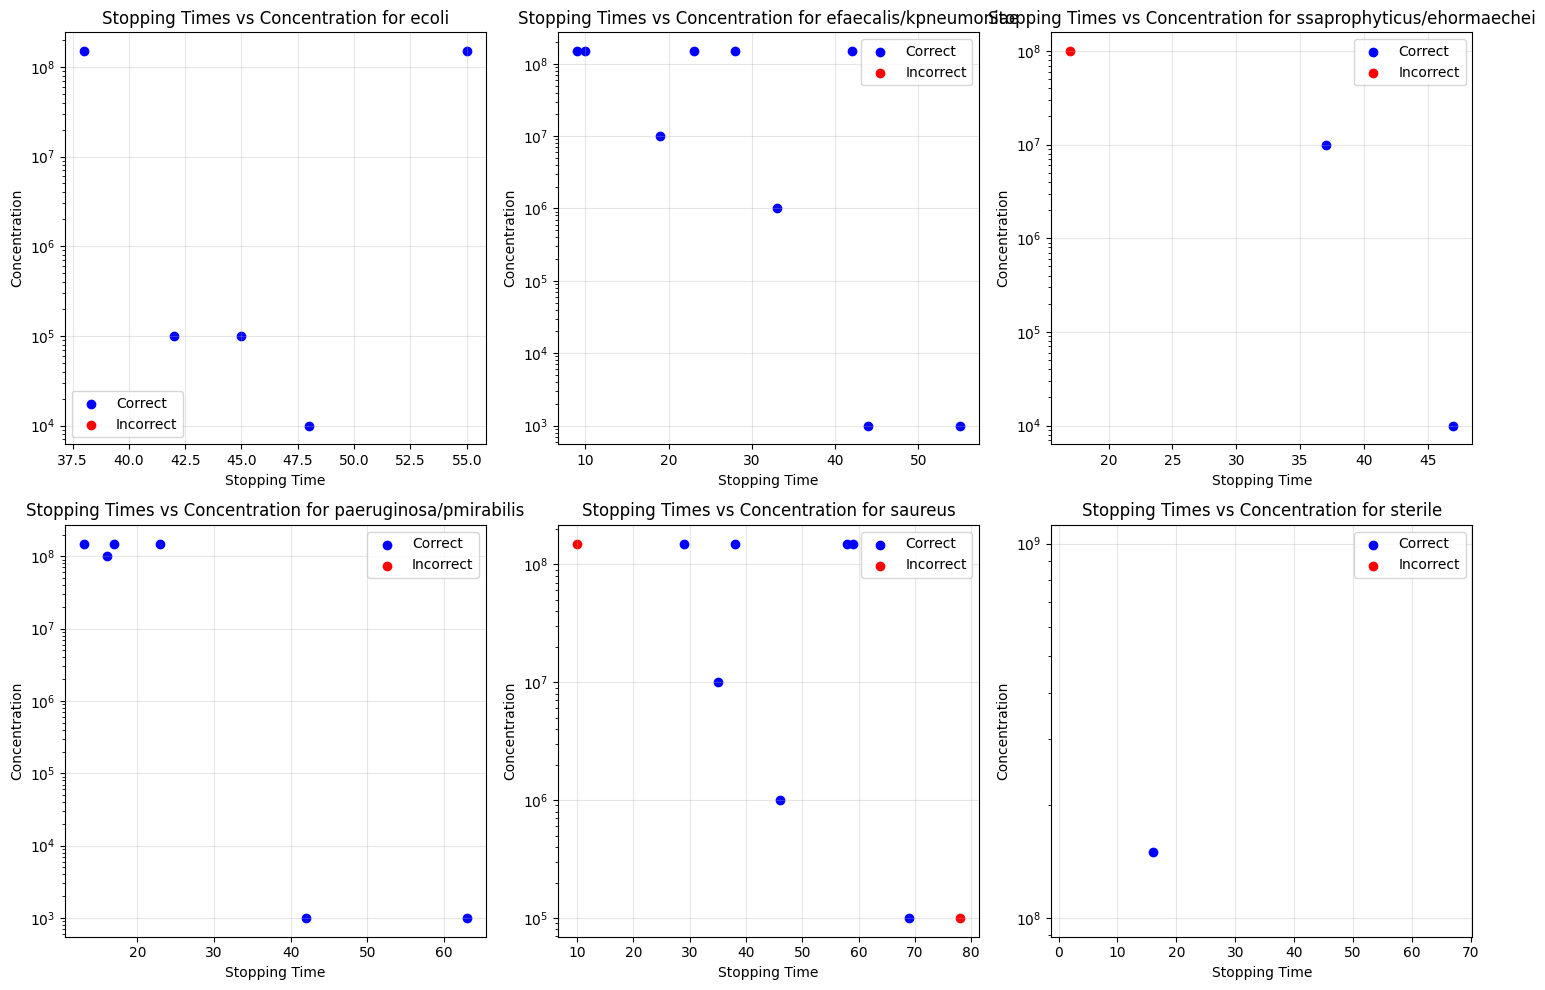

Accuracy: 0.8648648648648649
Earliness: 0.5445945945945946
Cost: 0.16236486486486482


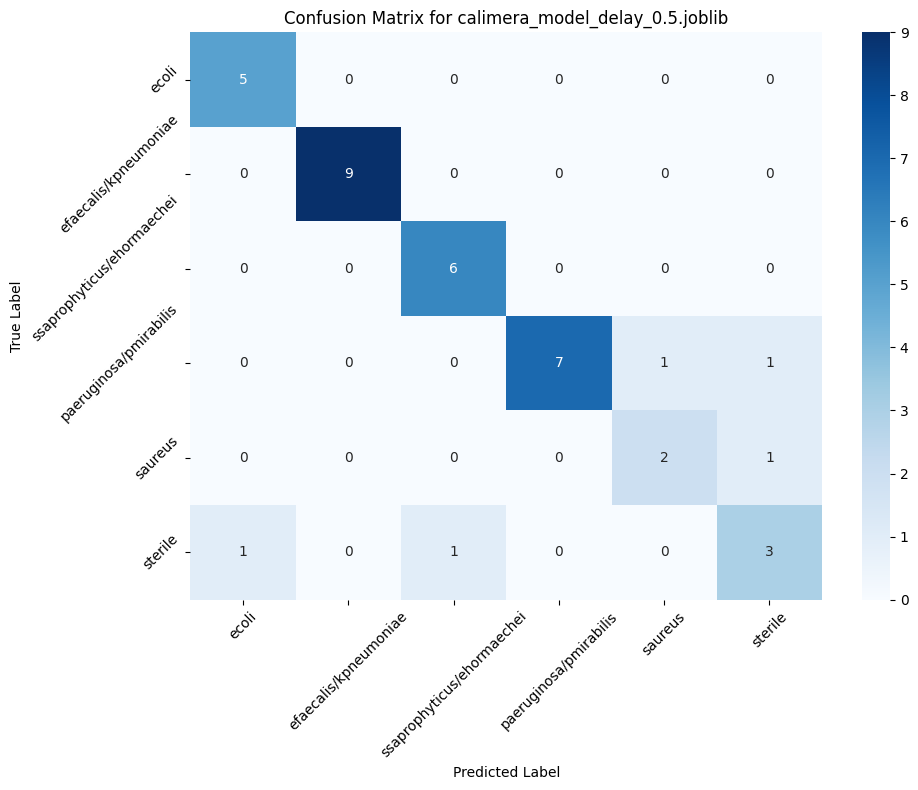

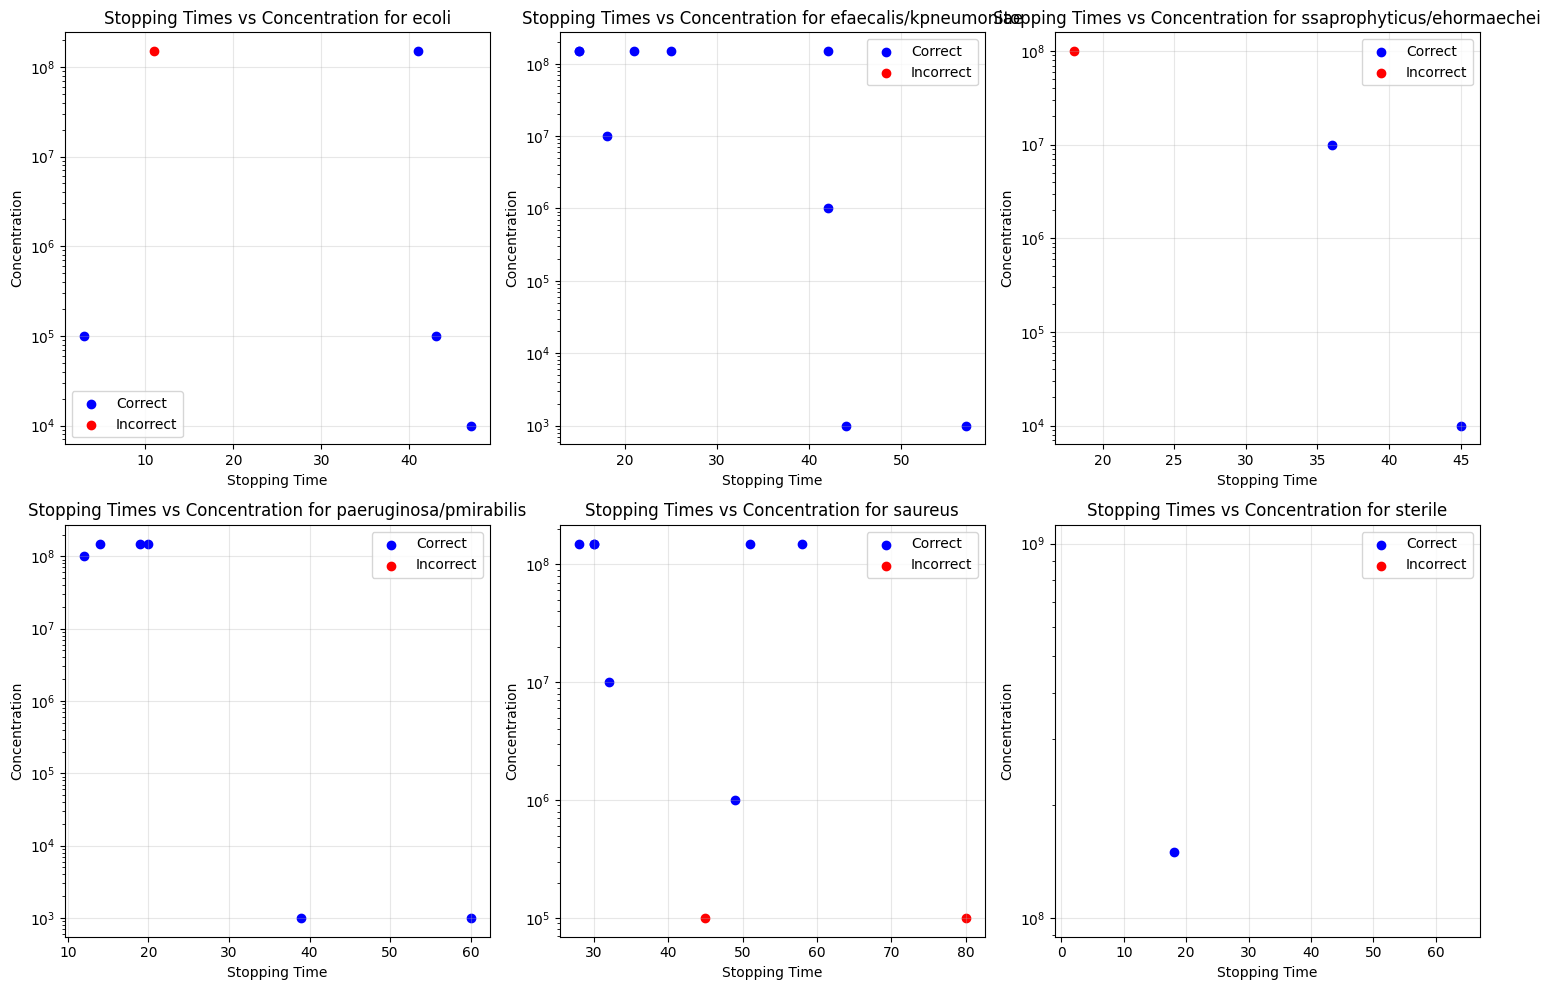

Accuracy: 0.8648648648648649
Earliness: 0.5797297297297297
Cost: 0.16991891891891886


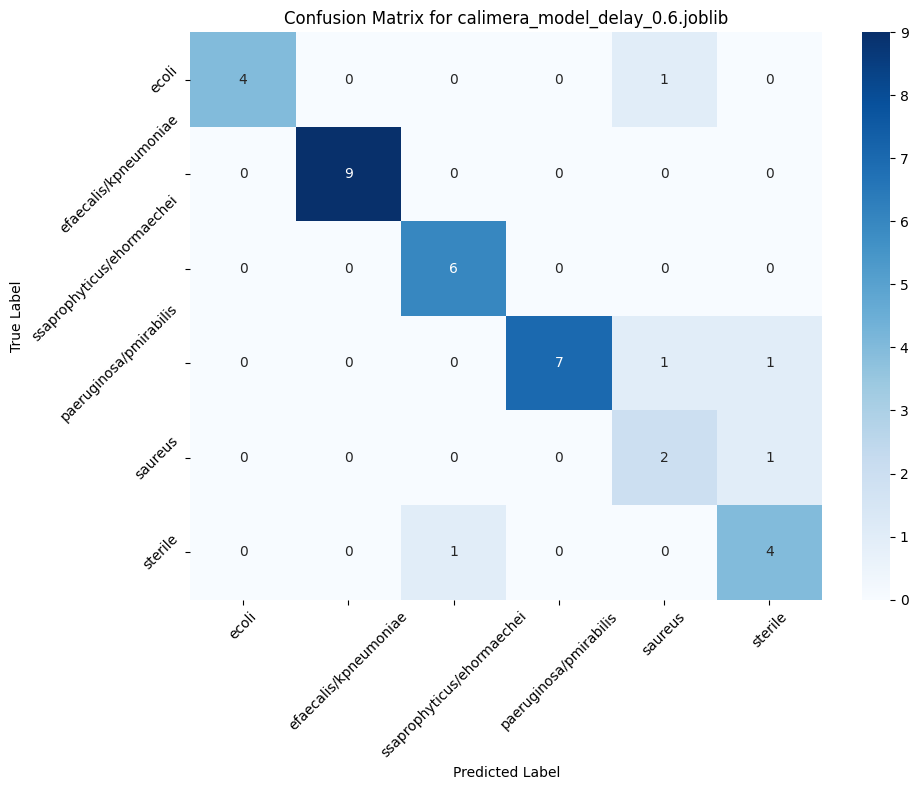

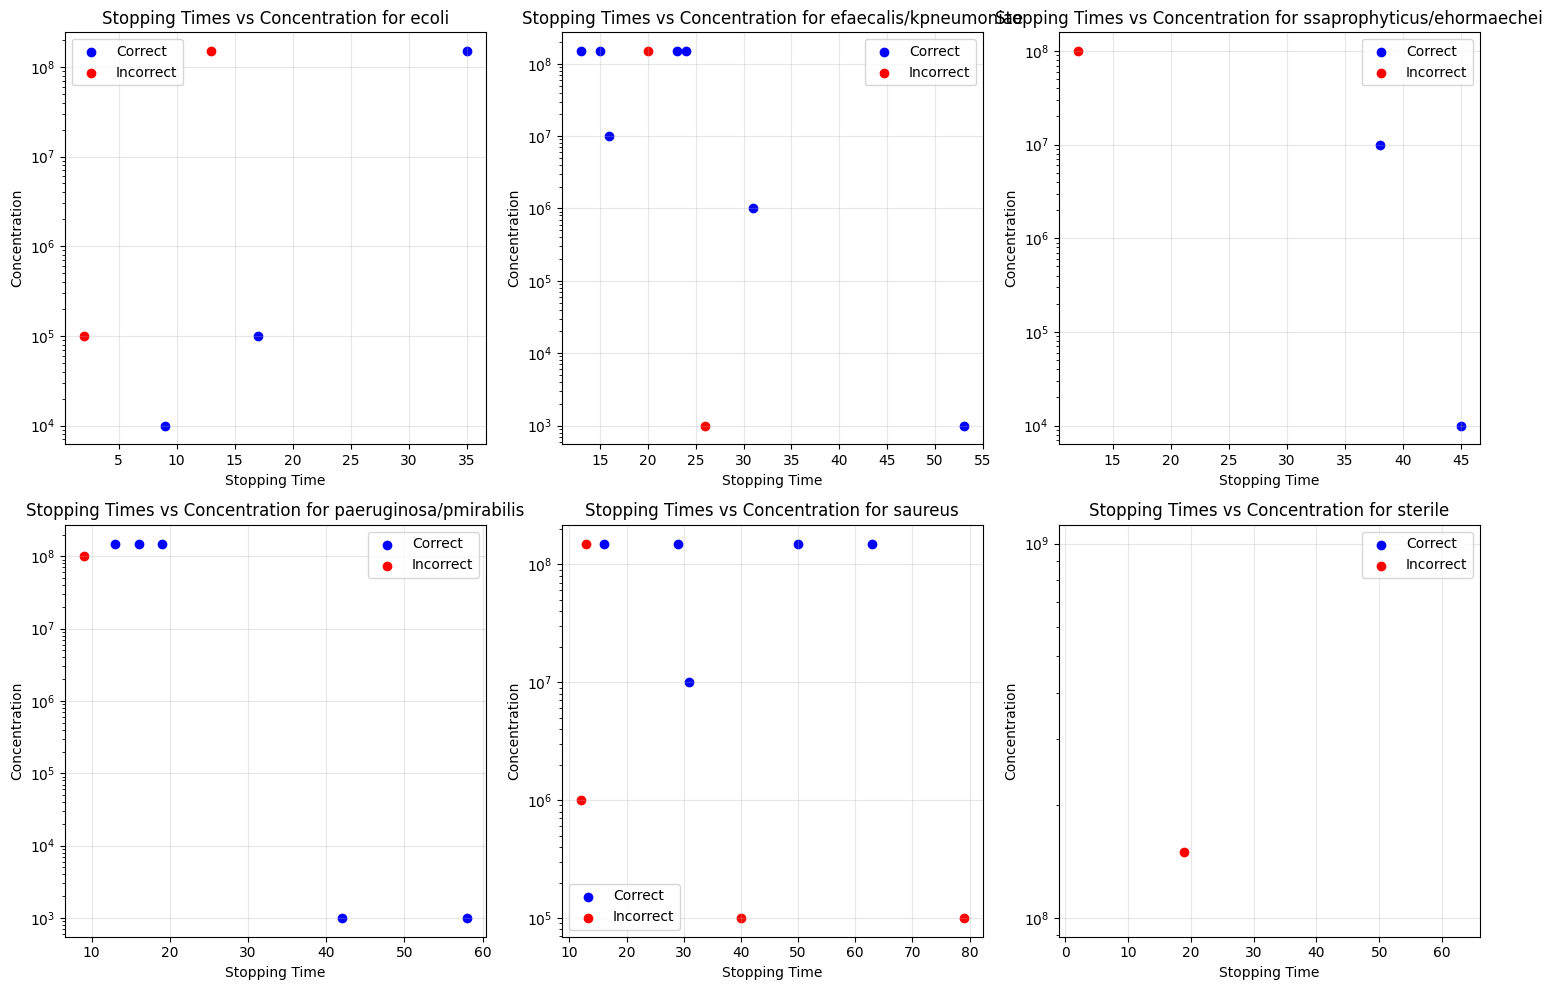

Accuracy: 0.6756756756756757
Earliness: 0.6516891891891892
Cost: 0.3699425675675676


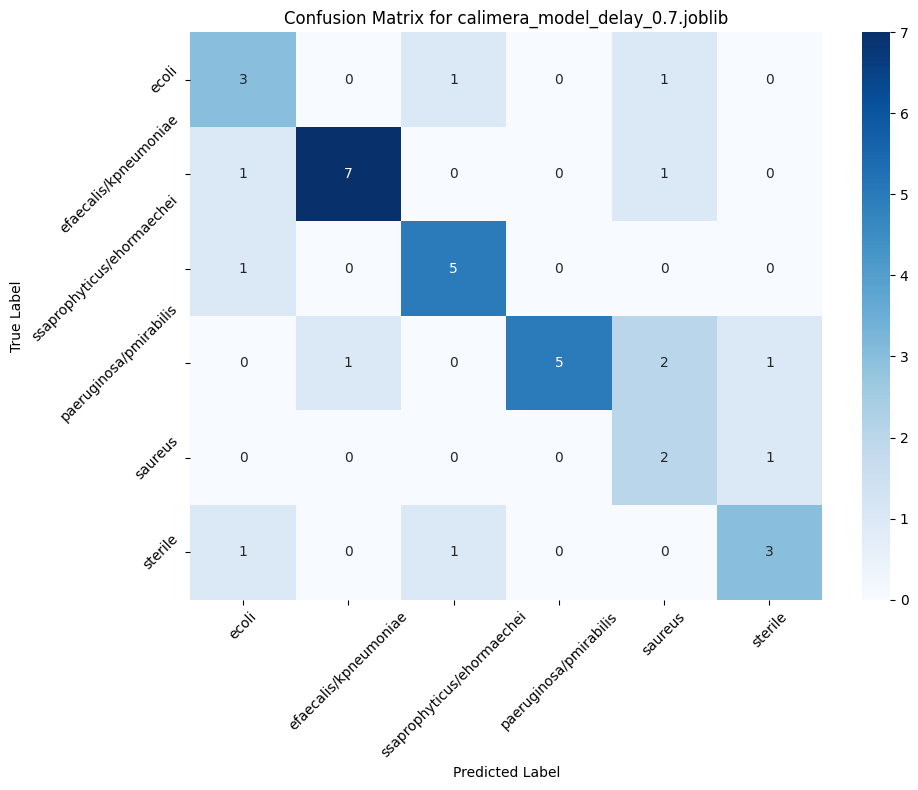

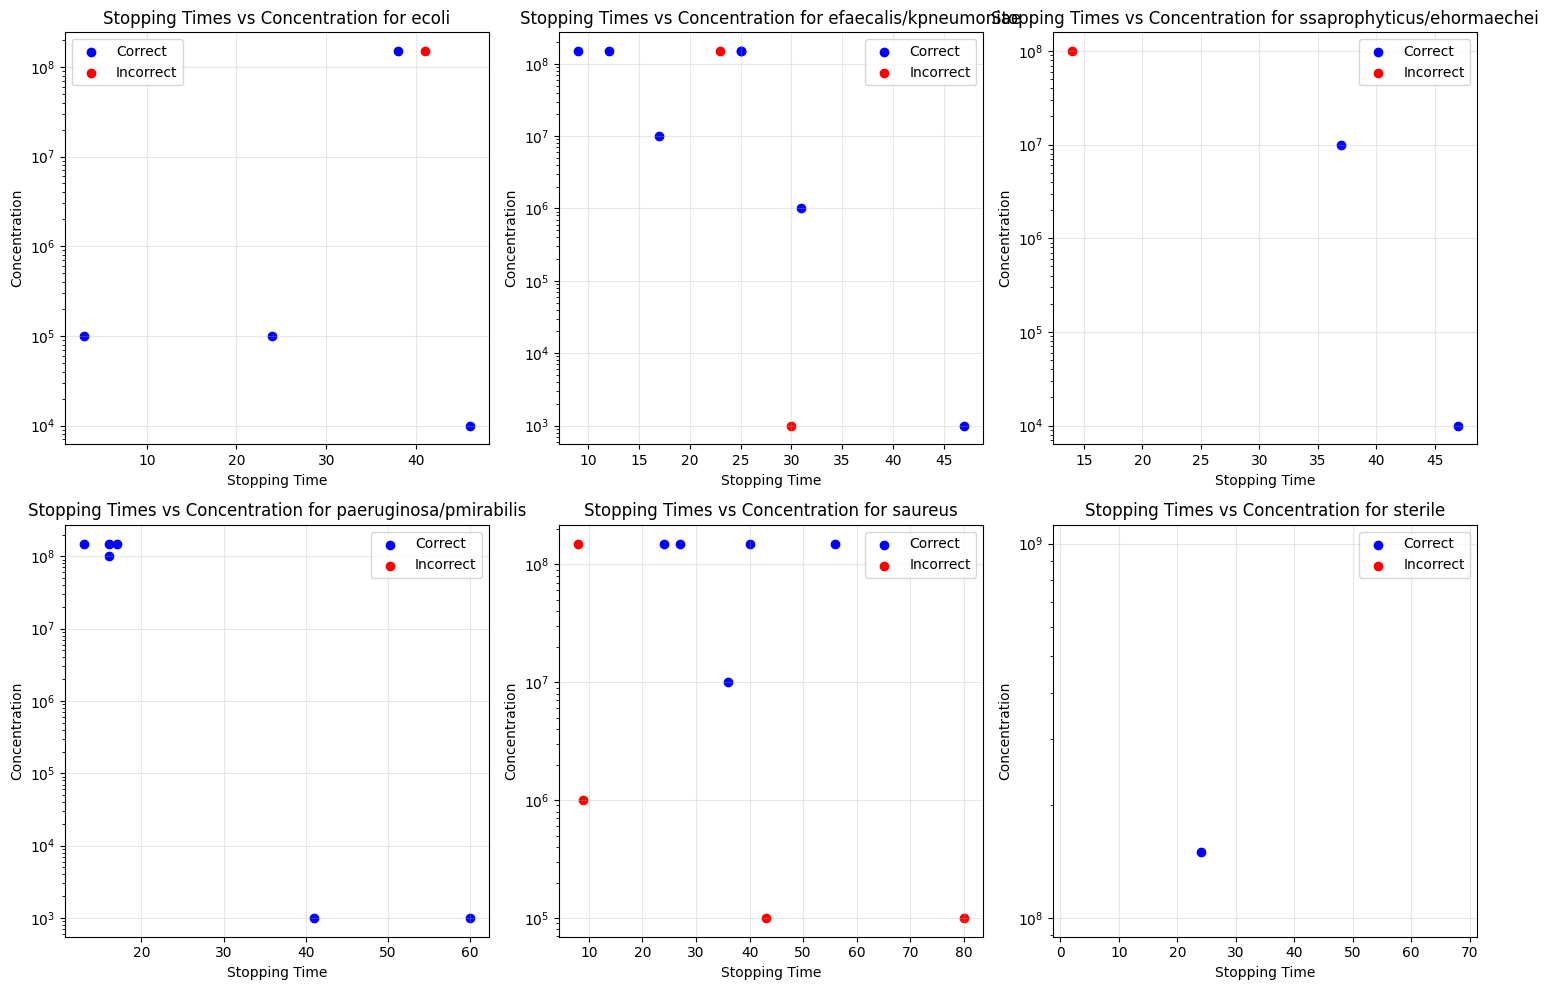

Accuracy: 0.7567567567567568
Earliness: 0.6260135135135135
Cost: 0.2933243243243243


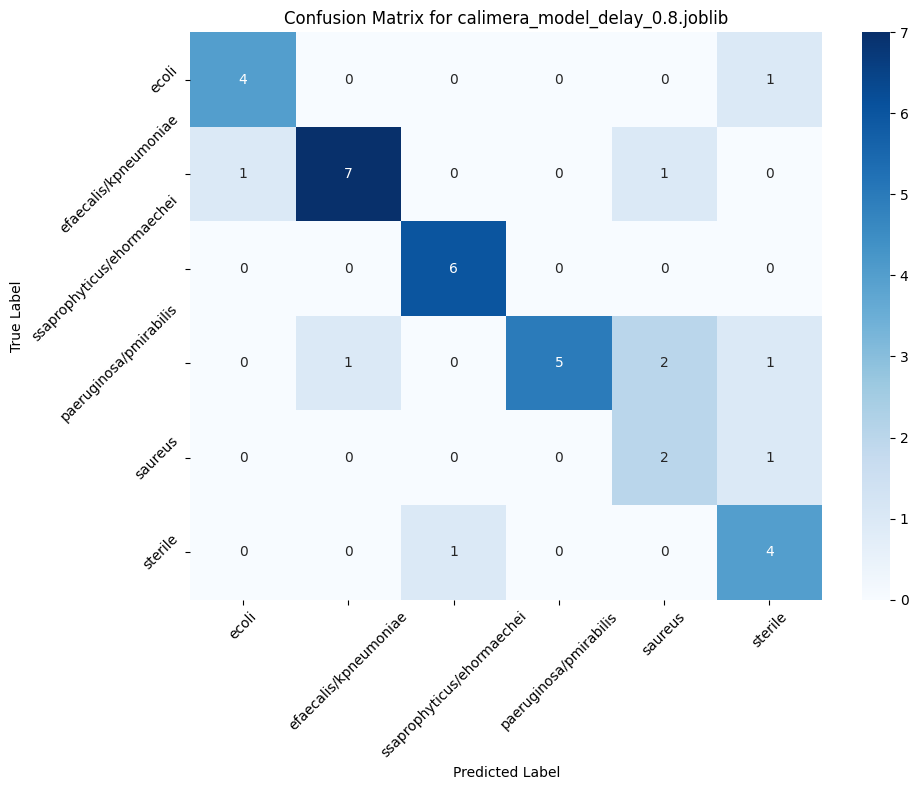

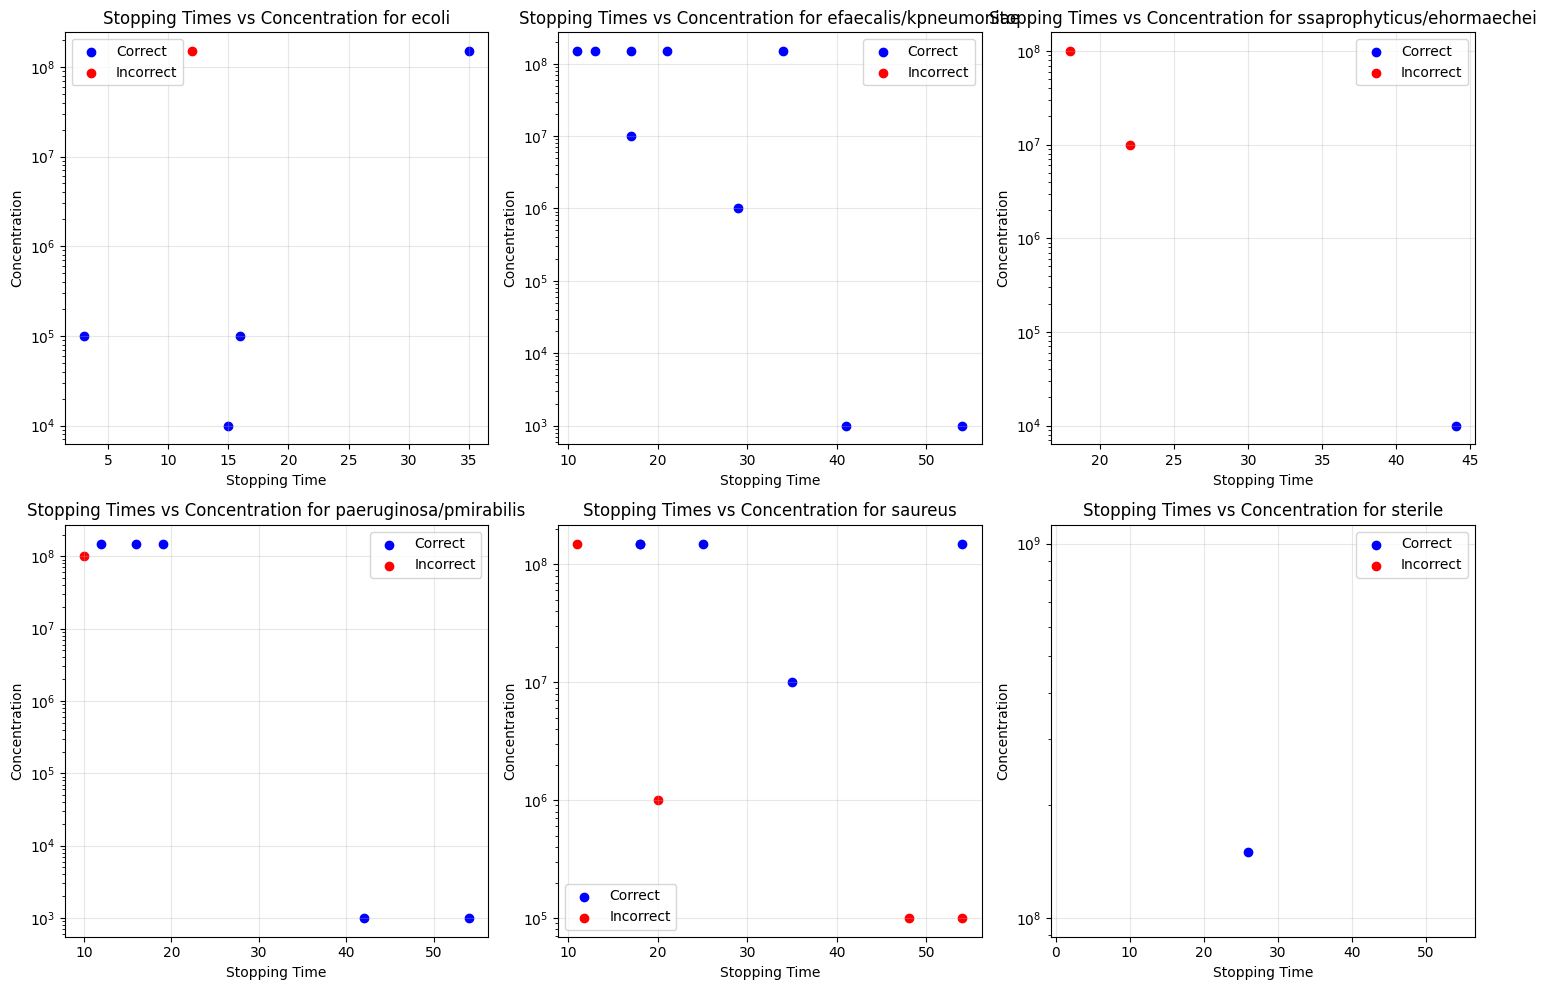

Accuracy: 0.7297297297297297
Earliness: 0.6699324324324325
Cost: 0.33056418918918923


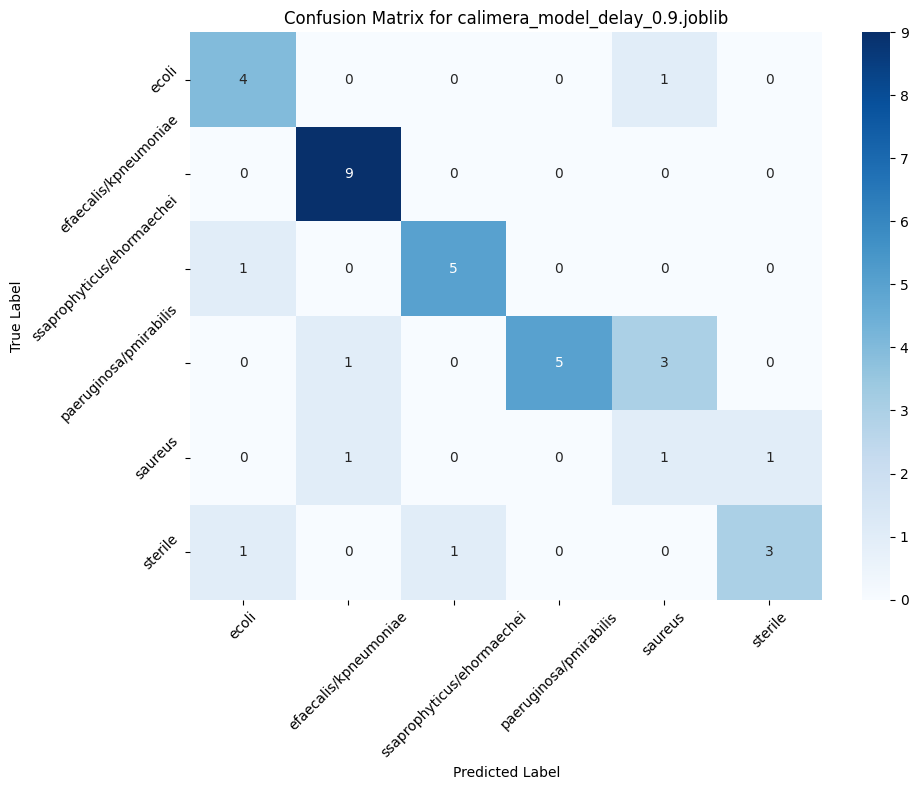

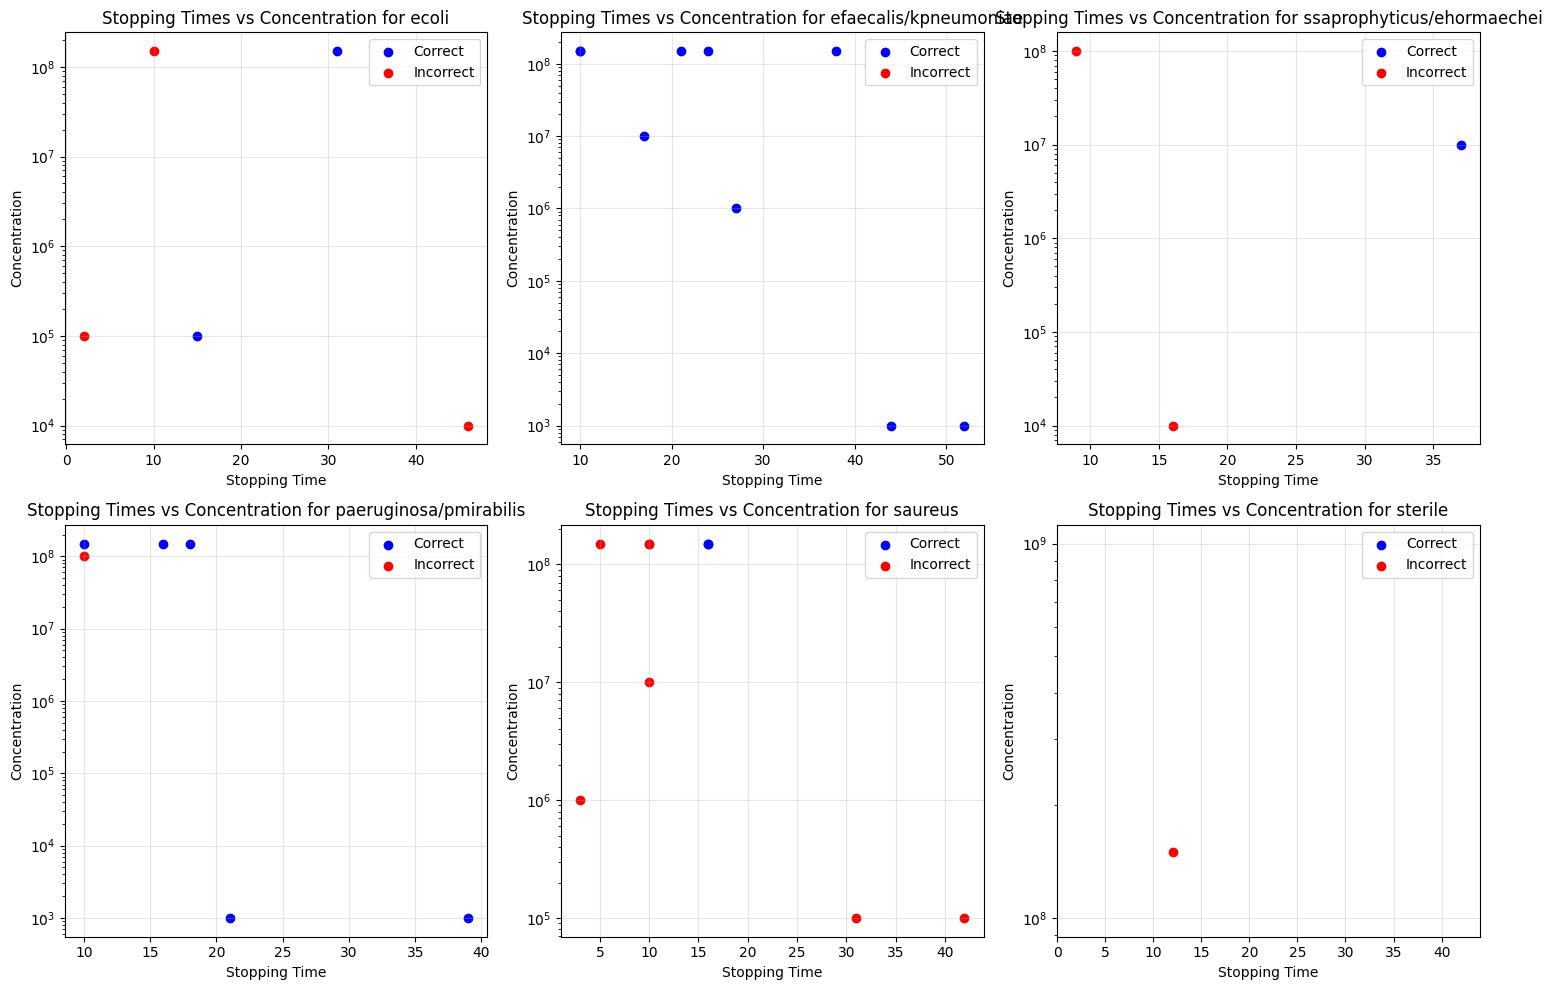

Accuracy: 0.5675675675675675
Earliness: 0.7543918918918919
Cost: 0.5078716216216217


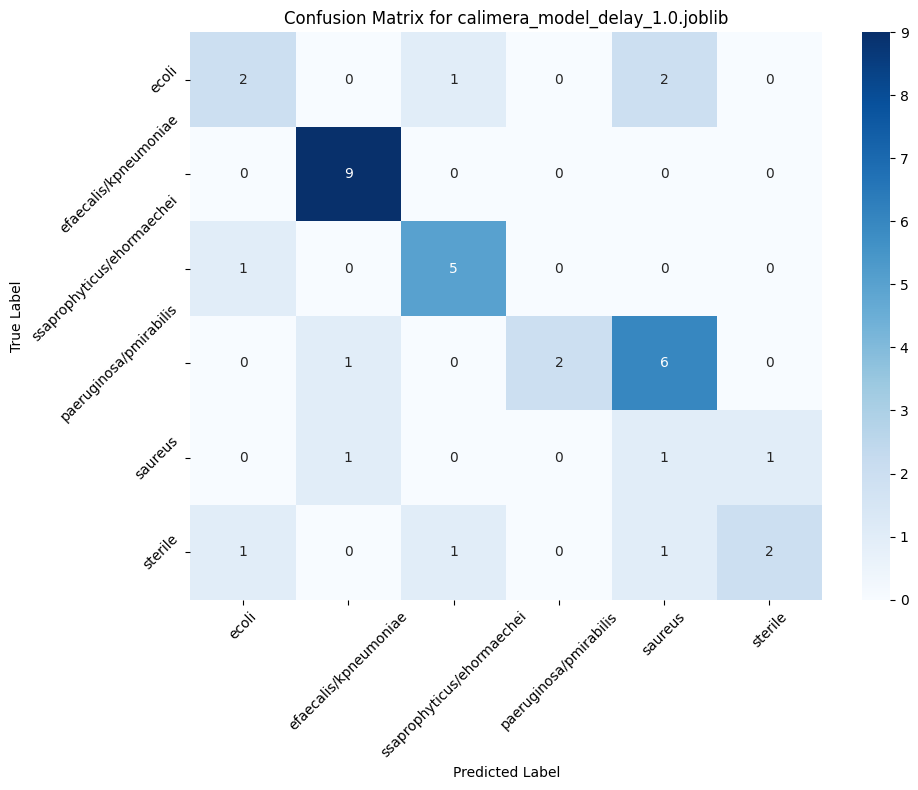

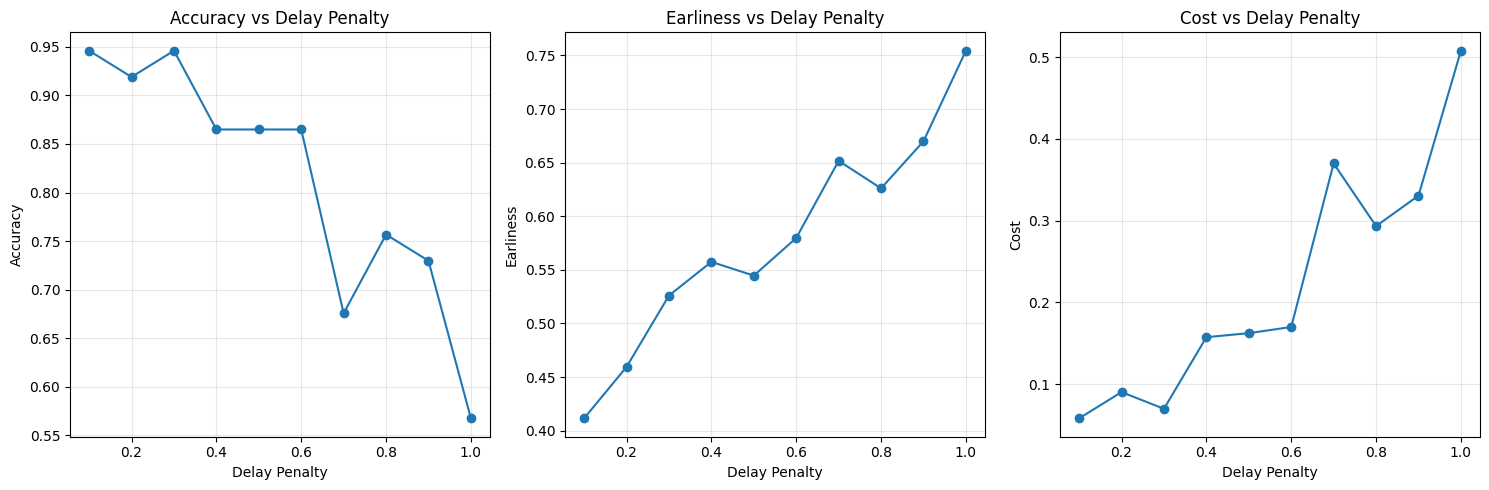

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import numpy as np

classes = ['ecoli', 'efaecalis/kpneumoniae', 'ssaprophyticus/ehormaechei', 
           'paeruginosa/pmirabilis', 'saureus', 'sterile']


models = [f for f in os.listdir('/media/storage/users/go98kef/CALIMERA/saved_models') if f.endswith('.joblib')]
root = '/media/storage/users/go98kef/CALIMERA/saved_models'
# Sort models based on the float delay number in the filename
models.sort(key=lambda x: float(x.split('_')[3].replace('delay_', '').replace('.joblib', '')))
m = 0
accuracy_scores = []
earliness_scores = []
cost_scores = []
for model in models:
    model = joblib.load(os.path.join(root, model))
    stop_timestamps, y_pred = model.test(X_test)

    bin_range = range(0, 80, 5)

    fig1, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

    class_stops_true = {class_name: [] for class_name in classes}
    class_stops_false = {class_name: [] for class_name in classes}

    # Fill dictionaries with stopping times for each class
    for stop, pred, true in zip(stop_timestamps, y_pred, y_test):
        if pred == true:
            class_stops_true[true].append(stop)
        else:
            class_stops_false[true].append(stop)

    # Create scatter plots for each class
    ax1.scatter([stop_timestamps[i] for i, true_class in enumerate(y_test) if true_class == classes[0] and y_pred[i] == y_test[i]], 
                [con_test[i] for i, true_class in enumerate(y_test) if true_class == classes[0] and y_pred[i] == y_test[i]], 
                c='blue', label='Correct')
    ax1.scatter([stop_timestamps[i] for i, true_class in enumerate(y_test) if true_class == classes[0] and y_pred[i] != y_test[i]], 
                [con_test[i] for i, true_class in enumerate(y_test) if true_class == classes[0] and y_pred[i] != y_test[i]], 
                c='red', label='Incorrect')
    ax1.set_title(f'Stopping Times vs Concentration for {classes[0]}')
    ax1.set_ylabel('Concentration')
    ax1.set_xlabel('Stopping Time')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.scatter([stop_timestamps[i] for i, true_class in enumerate(y_test) if true_class == classes[1] and y_pred[i] == y_test[i]], 
                [con_test[i] for i, true_class in enumerate(y_test) if true_class == classes[1] and y_pred[i] == y_test[i]], 
                c='blue', label='Correct')
    ax2.scatter([stop_timestamps[i] for i, true_class in enumerate(y_test) if true_class == classes[1] and y_pred[i] != y_test[i]], 
                [con_test[i] for i, true_class in enumerate(y_test) if true_class == classes[1] and y_pred[i] != y_test[i]], 
                c='red', label='Incorrect')
    ax2.set_title(f'Stopping Times vs Concentration for {classes[1]}')
    ax2.set_ylabel('Concentration')
    ax2.set_xlabel('Stopping Time')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    ax3.scatter([stop_timestamps[i] for i, true_class in enumerate(y_test) if true_class == classes[2] and y_pred[i] == y_test[i]], 
                [con_test[i] for i, true_class in enumerate(y_test) if true_class == classes[2] and y_pred[i] == y_test[i]], 
                c='blue', label='Correct')
    ax3.scatter([stop_timestamps[i] for i, true_class in enumerate(y_test) if true_class == classes[2] and y_pred[i] != y_test[i]], 
                [con_test[i] for i, true_class in enumerate(y_test) if true_class == classes[2] and y_pred[i] != y_test[i]], 
                c='red', label='Incorrect')
    ax3.set_title(f'Stopping Times vs Concentration for {classes[2]}')
    ax3.set_ylabel('Concentration')
    ax3.set_xlabel('Stopping Time')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    ax4.scatter([stop_timestamps[i] for i, true_class in enumerate(y_test) if true_class == classes[3] and y_pred[i] == y_test[i]], 
                [con_test[i] for i, true_class in enumerate(y_test) if true_class == classes[3] and y_pred[i] == y_test[i]], 
                c='blue', label='Correct')
    ax4.scatter([stop_timestamps[i] for i, true_class in enumerate(y_test) if true_class == classes[3] and y_pred[i] != y_test[i]], 
                [con_test[i] for i, true_class in enumerate(y_test) if true_class == classes[3] and y_pred[i] != y_test[i]], 
                c='red', label='Incorrect')
    ax4.set_title(f'Stopping Times vs Concentration for {classes[3]}')
    ax4.set_ylabel('Concentration')
    ax4.set_xlabel('Stopping Time')
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3)
    ax4.legend()

    ax5.scatter([stop_timestamps[i] for i, true_class in enumerate(y_test) if true_class == classes[4] and y_pred[i] == y_test[i]], 
                [con_test[i] for i, true_class in enumerate(y_test) if true_class == classes[4] and y_pred[i] == y_test[i]], 
                c='blue', label='Correct')
    ax5.scatter([stop_timestamps[i] for i, true_class in enumerate(y_test) if true_class == classes[4] and y_pred[i] != y_test[i]], 
                [con_test[i] for i, true_class in enumerate(y_test) if true_class == classes[4] and y_pred[i] != y_test[i]], 
                c='red', label='Incorrect')
    ax5.set_title(f'Stopping Times vs Concentration for {classes[4]}')
    ax5.set_ylabel('Concentration')
    ax5.set_xlabel('Stopping Time')
    ax5.set_yscale('log')
    ax5.grid(True, alpha=0.3)
    ax5.legend()

    ax6.scatter([stop_timestamps[i] for i, true_class in enumerate(y_test) if true_class == classes[5] and y_pred[i] == y_test[i]], 
                [con_test[i] for i, true_class in enumerate(y_test) if true_class == classes[5] and y_pred[i] == y_test[i]], 
                c='blue', label='Correct')
    ax6.scatter([stop_timestamps[i] for i, true_class in enumerate(y_test) if true_class == classes[5] and y_pred[i] != y_test[i]], 
                [con_test[i] for i, true_class in enumerate(y_test) if true_class == classes[5] and y_pred[i] != y_test[i]], 
                c='red', label='Incorrect')
    ax6.set_title(f'Stopping Times vs Concentration for {classes[5]}')
    ax6.set_ylabel('Concentration')
    ax6.set_xlabel('Stopping Time')
    ax6.set_yscale('log')
    ax6.grid(True, alpha=0.3)
    ax6.legend()

    plt.tight_layout()
    plt.show()

    delay_penalty = (m+1)/10
    accuracy = accuracy_score(y_test, y_pred)
    earliness = 1-sum(stop_timestamps) / (X_test.shape[-1] * X_test.shape[0])
    cost = 1.0 - accuracy + delay_penalty/10 * earliness
    print(f'Accuracy: {accuracy}\nEarliness: {earliness}\nCost: {cost}')

    accuracy_scores.append(accuracy)
    earliness_scores.append(earliness)
    cost_scores.append(cost)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.title(f'Confusion Matrix for {models[m]}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    m += 1

# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Get delay penalties from model names
delay_penalties = [float(model.split('_')[3].replace('delay_', '').replace('.joblib', '')) for model in models]

# Plot accuracy
ax1.plot(delay_penalties, accuracy_scores, marker='o')
ax1.set_xlabel('Delay Penalty')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Delay Penalty')
ax1.grid(True, alpha=0.3)

# Plot earliness
ax2.plot(delay_penalties, earliness_scores, marker='o')
ax2.set_xlabel('Delay Penalty')
ax2.set_ylabel('Earliness')
ax2.set_title('Earliness vs Delay Penalty')
ax2.grid(True, alpha=0.3)

# Plot cost
ax3.plot(delay_penalties, cost_scores, marker='o')
ax3.set_xlabel('Delay Penalty')
ax3.set_ylabel('Cost')
ax3.set_title('Cost vs Delay Penalty')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [54]:
model = CALIMERA(delay_penalty=0.5)
model.fit(X_train, y_train)

stop_timestamps, y_pred = model.test(X_test)

# Calculate average stopping time
avg_stopping_time = sum(stop_timestamps) / len(stop_timestamps)
median_stopping_time = np.median(stop_timestamps)
print(f'Average stopping time with delay penalty 1: {avg_stopping_time}')
print(f'Median stopping time with delay penalty 1: {median_stopping_time}')

# Calculate accuracy and earliness for comparison
accuracy = accuracy_score(y_test, y_pred)
earliness = 1 - sum(stop_timestamps) / (X_test.shape[-1] * X_test.shape[0])
print(f'Accuracy: {accuracy}')
print(f'Earliness: {earliness}')

/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/go98kef/.virtualenvs/venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(

Average stopping time with delay penalty 1: 33.37837837837838
Median stopping time with delay penalty 1: 29.0
Accuracy: 0.8648648648648649
Earliness: 0.5827702702702703
